In [ ]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pydot
import graphviz
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

NUM_CLASSES = 10
IMG_SIZE = 224
sns.set_style("whitegrid")

BATCH_SIZE = 32

def plot_history(history):
    epochs = range(1, len(history.history['accuracy']) + 1)

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], 'o-', label='Train Accuracy', color='tab:blue')
    plt.plot(epochs, history.history['val_accuracy'], 's-', label='Validation Accuracy', color='tab:orange')
    plt.fill_between(epochs, history.history['accuracy'], history.history['val_accuracy'],
                     color='gray', alpha=0.1)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Model Accuracy')
    plt.xticks(epochs)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], 'o-', label='Train Loss', color='tab:red')
    plt.plot(epochs, history.history['val_loss'], 's-', label='Validation Loss', color='tab:green')
    plt.fill_between(epochs, history.history['loss'], history.history['val_loss'],
                     color='gray', alpha=0.1)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Model Loss')
    plt.xticks(epochs)

    plt.tight_layout()
    plt.show()

In [ ]:
def preprocess_image(image, label):

  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))

  image = tf.cast(image, tf.float32)

  image = tf.keras.applications.efficientnet.preprocess_input(image)
  return image, label

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

CLASS_NAMES = [
    "airplane (0)",
    "automobile (1)",
    "bird (2)",
    "cat (3)",
    "deer (4)",
    "dog (5)",
    "frog (6)",
    "horse (7)",
    "ship (8)",
    "truck (9)",
]

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


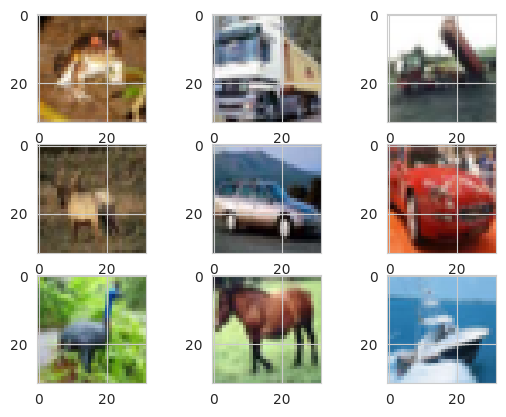

In [ ]:
for i in range(9):
  plt.subplot(3, 3, i + 1)
  plt.imshow(x_train[i])

plt.show()

In [ ]:
y_train = tf.keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = tf.keras.utils.to_categorical(y_test, NUM_CLASSES)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

train_dataset = train_dataset.batch(BATCH_SIZE).map(preprocess_image)
test_dataset = test_dataset.batch(BATCH_SIZE).map(preprocess_image)

In [ ]:
for images, labels in train_dataset.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)
    print("First label:", labels[0])

Image batch shape: (32, 224, 224, 3)
Label batch shape: (32, 10)
First label: tf.Tensor([0. 0. 0. 0. 0. 0. 1. 0. 0. 0.], shape=(10,), dtype=float64)


In [ ]:
base_model = keras.applications.EfficientNetB0(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    pooling='avg', weights='imagenet'
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
print('Layers in EfficientNETB0:', len(base_model.layers))

Layers in EfficientNETB0: 239


In [ ]:
base_model.trainable = False

In [ ]:
model = base_model.output

In [ ]:
model = keras.layers.BatchNormalization()(model)

model = keras.layers.Dense(512, kernel_regularizer=keras.regularizers.l2(0.0001))(model) # one more dense layer for deeper analysis - generalize without overfitting - gradual size reduction
model = keras.layers.BatchNormalization()(model)
model = keras.layers.Activation('swish')(model) # swish is smoother and helps early learning
model = keras.layers.Dropout(0.3)(model)

model = keras.layers.Dense(256, kernel_regularizer=keras.regularizers.l2(0.0001))(model) # smaller L2 penalty - better flexibililty
model = keras.layers.BatchNormalization()(model)
model = keras.layers.Activation('swish')(model) # swish is smoother and helps early learning
model = keras.layers.Dropout(0.2)(model) # 0.4 and 0.3 - less aggressive dropout to avoid underfitting and overfitting

model = keras.layers.Dense(128, kernel_regularizer=keras.regularizers.l2(0.0001))(model)
model = keras.layers.BatchNormalization()(model)
model = keras.layers.Activation('relu')(model) # relu for final compression.

predictions = keras.layers.Dense(NUM_CLASSES, activation="softmax")(model)

model = keras.models.Model(inputs=base_model.input, outputs=predictions)

# the model is learning consistently — both training and validation performance improve.

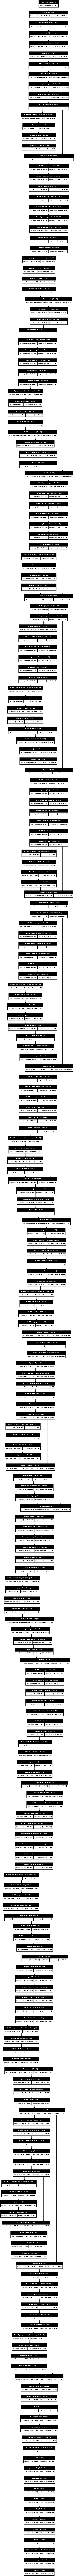

In [ ]:
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
model.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05), # reduce loss slight without hurting accuracy
    optimizer = keras.optimizers.Adam(1e-4),
    metrics = ["accuracy"]
)

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

In [ ]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='EfficientNetB0_CIFAR10.keras',
    save_best_only=True,
    monitor='val_accuracy'
)

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [ ]:
history = model.fit(train_dataset,
                    validation_data=test_dataset,
                    epochs=20,
                    callbacks=[checkpoint_callback,reduce_lr, early_stopping]
)

Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 120s 59ms/step - accuracy: 0.6910 - loss: 1.2363 - val_accuracy: 0.8903 - val_loss: 0.7161 - learning_rate: 1.0000e-04
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 114s 50ms/step - accuracy: 0.8605 - loss: 0.7891 - val_accuracy: 0.9042 - val_loss: 0.6775 - learning_rate: 1.0000e-04
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 50ms/step - accuracy: 0.8824 - loss: 0.7289 - val_accuracy: 0.9078 - val_loss: 0.6598 - learning_rate: 1.0000e-04
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 83s 51ms/step - accuracy: 0.8925 - loss: 0.6950 - val_accuracy: 0.9114 - val_loss: 0.6483 - learning_rate: 1.0000e-04
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 51ms/step - accuracy: 0.9042 - loss: 0.6648 - val_accuracy: 0.9166 - val_loss: 0.6377 - learning_rate: 1.0000e-04
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 72s 44ms/step - accuracy: 0.9103 - loss: 0.6472 - val_accuracy: 0.9153 - val_loss: 0.6324 - learning_rate: 1.0000e-04
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━

In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)

print(f"Test Accuracy: {test_accuracy: .4f}")
print(f"Test Loss: {test_loss: .4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.9175 - loss: 0.6133
Test Accuracy:  0.9193
Test Loss:  0.6031


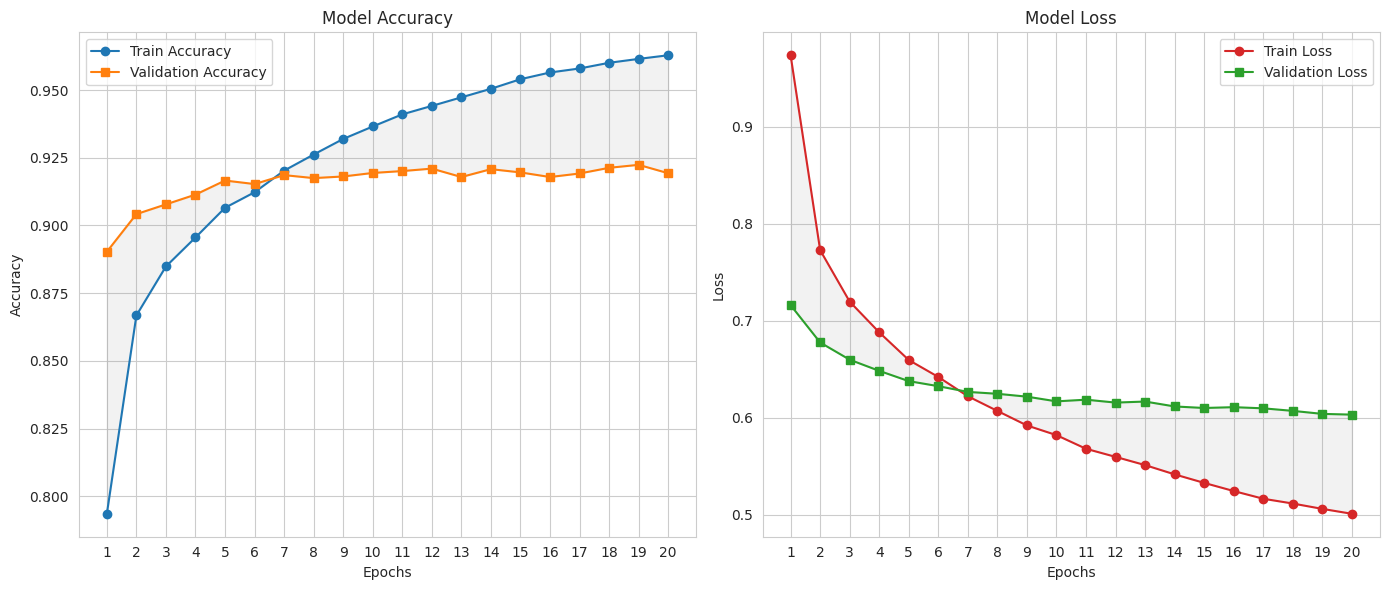

In [ ]:
plot_history(history)

# both training and validation accuracy rise steadily and stay close together = not overfitting
# both training and validation loss go down smoothly and stay close = not underfitting

In [ ]:
%%capture
y_true_classes = []
y_pred_classes = []

for X_batch, y_batch in test_dataset:
    y_true_classes.extend(np.argmax(y_batch.numpy(), axis=1))
    y_pred_classes.extend(np.argmax(model.predict(X_batch), axis=1)
)

In [ ]:
y_true_classes = np.array(y_true_classes)
y_pred_classes = np.array(y_pred_classes)

In [ ]:
cm = confusion_matrix(y_true_classes, y_pred_classes)

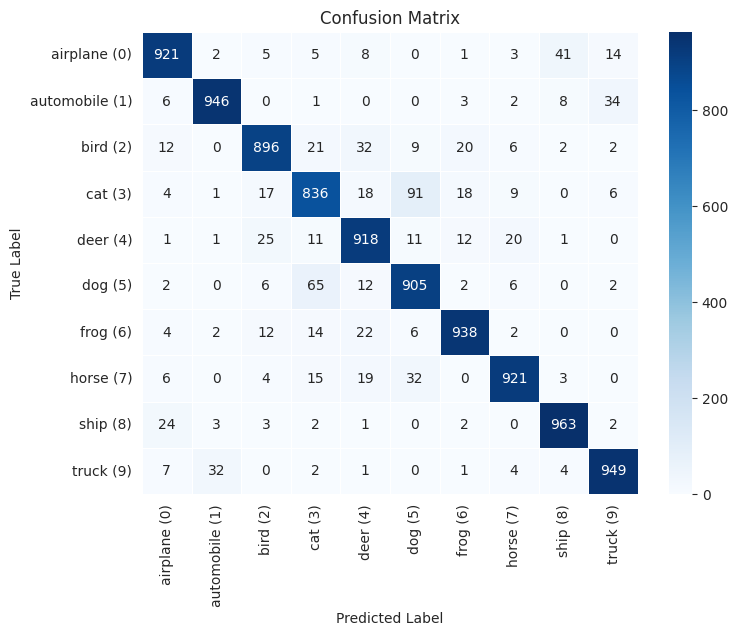

In [ ]:
# @title
plt.figure(figsize=(8, 6))
sns.heatmap(cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    linewidths=0.5,
    xticklabels=CLASS_NAMES,
    yticklabels=CLASS_NAMES
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()